In [1]:
# load the ES_part_x files up to number 11 into df_es
import numpy as np
import pandas as pd
df_es = pd.DataFrame()

for i in range(1, 12):
    file_name = f'ES_part_{i}.csv'
    try:
        df_part = pd.read_csv(file_name)
        df_es = pd.concat([df_es, df_part], ignore_index=True)
    except FileNotFoundError:
        print(f"File {file_name} not found. Skipping.")


# set Date column to datetime
df_es['Date'] = pd.to_datetime(df_es['Date'], errors='coerce')

# set Date as index and combine date with Time column so that it is a datetime index
df_es['DateTime'] = pd.to_datetime(df_es['Date'].astype(str) + ' ' + df_es['Time'], errors='coerce')
df_es.set_index('DateTime', inplace=True)
# drop the original Date and Time columns
df_es.drop(columns=['Date', 'Time'], inplace=True)
# sort the index
df_es.sort_index(inplace=True)


# Surprise Dataframe
# Load the Surprise dataset
df_surprise = pd.read_csv('US_economic_releases_events.csv')

df_surprise.drop(columns=['S', 'Month', 'Surv(A)', 'Surv(H)', 'Surv(L)', 'Flag', 'Country/Region', 'Day', 'C', 'Category','Subcategory', 'Period', 'Actual'], inplace=True)
# Drop rows where surprise is NaN or -- (indicating no surprise)
df_surprise.dropna(subset=['Surprise'], inplace=True)
df_surprise = df_surprise[df_surprise['Surprise'] != '--']
# remove surprise values that are NaN or 0
df_surprise = df_surprise[df_surprise['Surprise'].notna() & (df_surprise['Surprise'] != 0)]
# Change surprise column to numeric, coercing errors
df_surprise['Surprise'] = pd.to_numeric(df_surprise['Surprise'], errors='coerce')

# Drop rows where Time is NaN
df_surprise.dropna(subset=['Time'], inplace=True)

# Convert Unnamed: 0 column to datetime
df_surprise['Unnamed: 0'] = pd.to_datetime(df_surprise['Unnamed: 0'], errors='coerce')
# Combine datetime column with Time column and set as index
df_surprise['DateTime'] = pd.to_datetime(df_surprise['Unnamed: 0'].astype(str) + ' ' + df_surprise['Time'], errors='coerce')
df_surprise.set_index('DateTime', inplace=True)
# Drop the original Unnamed: 0 and Time columns
df_surprise.drop(columns=['Unnamed: 0', 'Time'], inplace=True)
# Sort the index
df_surprise.sort_index(inplace=True)

# remove surprise values that are NaN or 0
df_surprise = df_surprise[df_surprise['Surprise'].notna() & (df_surprise['Surprise'] != 0)]

# Wincorsizing to get results between 0.5% and 99.5% percentile for Surprise values

lower_bound = df_surprise['Surprise'].quantile(0.005)
upper_bound = df_surprise['Surprise'].quantile(0.995)

df_surprise = df_surprise[(df_surprise['Surprise'] >= lower_bound) & (df_surprise['Surprise'] <= upper_bound)]


# Combining the 2 dataframes on the index
# outer join the two DataFrames on the index
df_combined = pd.merge(df_es, df_surprise, left_index=True, right_index=True, how='outer', suffixes=('_es', '_surprise'))

# remove all rows with NaN values in Open Close / Volume - Do not take out volume, can be 0 (not necessarily a mistake)
df_combined.dropna(subset=['Open', 'Close'], inplace=True)

# Adding a column called 'Volume_L1' which is the Volume shifted by 1 day - which is the volume of the previous minute matched up with the current minute
df_combined['Volume_L1'] = df_combined['Volume'].shift(1)

# Now we create the technical explanatory variables based on literature

def create_technical_features(df):
    """
    Creates all technical features for a dataframe containing price/volume data
    and three return columns (Return, Return_half, Return_double)
    """
    # 1. Original Features
    df_combined['Volume'] = df_combined['Volume']
    df_combined['Price'] = df_combined['Open']

    # 2. Simple Moving Averages (now includes all required windows)
    ma_windows = [5, 10, 15, 20, 50, 100, 200]  # Added missing windows for crossovers
    for window in ma_windows:
        df[f'SMA{window}'] = df['Close'].rolling(window).mean() 

    # 3. Moving Average Crossovers (now all SMAs exist)
    for window in [5, 10, 15, 20, 50, 100, 200]:
        # No more need for existence check since we created all SMAs
        df[f'SMA{window}Cross'] = (df['Close'] > df[f'SMA{window}']).astype(int) # 1 for above SMA, 0 for below

    # 4. Consecutive Price Trends
    trend_periods = [10, 15, 50]
    for period in trend_periods:
        df[f'UpDown{period}'] = np.sign(df['Close'].pct_change(period)) # 1 for up, -1 for down, NaN for no change

    # Ensure we keep the original return columns
    return_cols = ['Return', 'Return_half', 'Return_double']
    for col in return_cols:
        if col in df.columns:
            df[col] = df[col]  # Maintain existing returns

    return df

# Example usage:
# df_combined must contain: 'volume', 'close' columns plus the 3 return columns
df_combined = create_technical_features(df_combined)

import datetime
import pandas as pd
import pandas_datareader as pdr

# --- 1. Set Start and End Dates, matches up with last date of df_combined ---
start = df_combined.index.min() # Get the first date from df_combined
end = df_combined.index.max()  # Get the last date from df_combined

# print start and end
print(f"Start Date: {start}, End Date: {end}")

# --- 2. Get GDP Growth Data ---
gdp_gr = pdr.DataReader('A191RL1Q225SBEA', 'fred', start, end)

# Create gdp_gr_ml dataframe
gdp_gr_ml = gdp_gr.reset_index()
gdp_gr_ml.rename(columns={'A191RL1Q225SBEA': 'gdp_gr'}, inplace=True)
gdp_gr_ml['DateTime'] = pd.to_datetime(gdp_gr_ml['DATE']) + pd.Timedelta(hours=23, minutes=59)
gdp_gr_ml = gdp_gr_ml[['DateTime', 'gdp_gr']]

# for both datasets set 'DateTime' as index and then drop columns
gdp_gr_ml.set_index('DateTime', inplace=True)

# make sure sorted on datetime
gdp_gr_ml.sort_index(inplace=True)


# Combine with Final Dataframe

# Merge the last known GDP growth merge on index
df_combined = pd.merge_asof(
    df_combined,
    gdp_gr_ml,
    on='DateTime',
    direction='backward'
)

# Rename the merged columns to last_gdp_gr and last_vix
df_combined = df_combined.rename(columns={
    'gdp_gr': 'last_gdp_gr'
})

# Set DateTime column as Index
df_combined.set_index('DateTime', inplace=True)

def calculate_daily_realized_volatility(df, freq='5min', close_col='Close'):
    """
    Calculates the daily realized volatility (non-annualized) from intraday data.

    Args:
        df (pd.DataFrame): DataFrame with a datetime index and a close price column.
        freq (str): The sampling frequency (e.g., '1min', '5min', '15min').
        close_col (str): The name of the close price column.

    Returns:
        pd.Series: A Series of daily (non-annualized) realized volatility.
    """
    # Ensure the index is a DatetimeIndex
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("The DataFrame index must be a DatetimeIndex.")
        
    # Resample the close price to the desired frequency
    df_resampled = df[close_col].resample(freq).last()

    # Calculate log returns
    log_returns = np.log(df_resampled).diff().dropna()

    # Group by day and calculate the sum of squared returns (realized variance)
    realized_variance_daily = (log_returns**2).resample('D').sum()
    
    # Filter out days with no trading activity
    realized_variance_daily = realized_variance_daily[realized_variance_daily > 0]
    
    # Calculate daily volatility (standard deviation), which is the square root of variance.
    # The result is NOT annualized, making it suitable for ML models.
    realized_volatility_daily = np.sqrt(realized_variance_daily)
    
    return realized_volatility_daily.dropna()


def analyze_and_add_volatility(df_combined):
    """
    Calculates daily realized volatility and adds it as a new column
    to the provided DataFrame in-place.

    Args:
        df_combined (pd.DataFrame): Your DataFrame with minute-level data.
                                    It must have a DatetimeIndex and a 'Close' column.
                                    This function modifies the DataFrame in-place.
    
    Returns:
        pd.DataFrame: The modified DataFrame with the new 'daily realized volatility' column.
    """
    # --- 1. Calculate Volatility ---
    # We use a 5-minute interval as a standard practice to balance capturing
    # volatility information and reducing market microstructure noise.
    # You can change this value if needed.
    sampling_interval = '5min'
    print(f"Calculating daily realized volatility using a '{sampling_interval}' sampling interval...")
    
    daily_volatility = calculate_daily_realized_volatility(
        df_combined, 
        freq=sampling_interval, 
        close_col='Close' # Using 'Close' with a capital C
    )

    # --- 2. Add Volatility Column to DataFrame ---
    # Map the calculated daily volatility back to the original minute-level DataFrame.
    # Each row will have the realized volatility value for its corresponding day.
    print("Adding 'daily realized volatility' column to the DataFrame...")
    # Normalize index to match the daily frequency of the volatility series
    df_combined['daily realized volatility'] = df_combined.index.normalize().map(daily_volatility)
    
    print("\n'daily realized volatility' column has been added successfully.")
        
    return df_combined


# --- HOW TO USE ---
if __name__ == '__main__':
    # 1. Make sure your DataFrame `df_combined` is loaded and available.
    #    It must have a DatetimeIndex and columns named:
    #    'open', 'high', 'low', 'Close', 'tick_count', 'volume'.
    #
    # Example of loading your data:
    # df_combined = pd.read_csv('path/to/your/futures_data.csv', 
    #                           parse_dates=['timestamp_column'], 
    #                           index_col='timestamp_column')

    # 2. Once `df_combined` is loaded, uncomment and run the following line:
    # df_combined_with_vol = analyze_and_add_volatility(df_combined)
    
    print("Script is ready. Please load your 'df_combined' DataFrame and call 'analyze_and_add_volatility(df_combined)' to start.")
    
    # For demonstration, if a variable named `df_combined` exists, we'll run the analysis.
    if 'df_combined' in locals() or 'df_combined' in globals():
        print("\n'df_combined' detected. Running analysis...")
        df_combined_with_vol = analyze_and_add_volatility(df_combined)

C:\Users\jopbr\AppData\Local\Temp\ipykernel_35724\4033720674.py:29: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df_surprise = pd.read_csv('US_economic_releases_events.csv')


Start Date: 1997-09-10 00:01:00, End Date: 2024-12-19 16:00:00
Script is ready. Please load your 'df_combined' DataFrame and call 'analyze_and_add_volatility(df_combined)' to start.

'df_combined' detected. Running analysis...
Calculating daily realized volatility using a '5min' sampling interval...


c:\Users\jopbr\miniconda3\envs\intel_env\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Adding 'daily realized volatility' column to the DataFrame...

'daily realized volatility' column has been added successfully.


In [2]:
import pandas as pd
import numpy as np

# --- Assumed DataFrame ---
# This code assumes you have a pre-existing DataFrame named 'df_combined'
# with a 'Close' price column.

# --- Configuration ---
# Base holding period. For data in minutes, this represents 20 minutes.
holding_period = 20

# Define the horizons for calculation.
horizons = ['', '_half', '_double']

# --- Main Loop to Generate Columns ---
for h in horizons:
    # 1. Determine the calculation period and descriptive minute value
    if h == '_half':
        period = holding_period // 2
        minutes = holding_period // 2
    elif h == '_double':
        period = holding_period * 2
        minutes = holding_period * 2
    else:  # h == ''
        period = holding_period
        minutes = holding_period

    # 2. Define the new, descriptive column names
    return_col_name = f'Forward Return ({minutes} min)'
    target_col_name = f'Target Signal ({minutes} min)'

    # 3. Calculate the base forward return using the 'Close' price.
    # This shifts the future 'Close' price to the current row to represent
    # the potential return from a trade initiated now.
    future_price = df_combined['Close'].shift(-period)
    current_price = df_combined['Close']

    # Calculate return for a long position (buy low, sell high)
    long_return = (future_price / current_price) - 1

    # Calculate return for a short position (sell high, buy low)
    short_return = (current_price / future_price) - 1

    # 4. Create the Forward Return column.
    # This represents the gross percentage return for a long position.
    df_combined[return_col_name] = long_return

    # 5. Create the categorical "Target Signal" column.
    # The target is based on whether a trade is profitable, ignoring costs.
    # 0 = Hold, 1 = Buy, 2 = Sell

    # "Buy" signal is generated if the long return is positive.
    cond_buy = long_return > 0

    # "Sell" signal is generated if the short return is positive.
    cond_sell = short_return > 0

    # Apply the signals to the target column
    df_combined[target_col_name] = 0  # Default to Hold
    df_combined.loc[cond_buy, target_col_name] = 1
    df_combined.loc[cond_sell, target_col_name] = 2

# The 'df_combined' DataFrame is now updated with the six new columns,
# calculated without considering transaction costs.

In [3]:
import pandas as pd
import numpy as np

# This script assumes 'df_combined' is an existing DataFrame with a DateTimeIndex
# and columns 'Ticker' and 'Surprise'.

# --- 1. Filter for Event Rows Only ---
# First, create a smaller dataframe that only contains rows where a surprise occurred.
# This makes the pivot operation much more efficient.
print("Step 1: Filtering for rows with surprise events...")
surprise_events_only = df_combined[df_combined['Surprise'].notna()].copy()
print(f"Found {len(surprise_events_only)} rows with surprise events to pivot.")


# --- 2. Pivot the Filtered Data ---
# Now, we pivot this smaller dataframe.
# - The index of the new dataframe will be the original DateTimeIndex.
# - New columns will be created from the unique values in the 'Ticker' column.
# - The values for these new columns will be taken from the 'Surprise' column.
# - `fill_value=0` is critical: it ensures that for any given event row, all ticker
#   columns that were NOT part of that event are filled with 0.
print("\nStep 2: Pivoting the data...")
event_df = surprise_events_only.pivot_table(
    index=surprise_events_only.index,
    columns='Ticker',
    values='Surprise',
    fill_value=0
)

# Optional: Add a suffix to the new column names for clarity
event_df = event_df.add_suffix('_Surprise')
print("Pivoting complete.")


# --- 3. Verify the Result ---
print("\n--- Event DataFrame Sample ---")
print(event_df.head())

print(f"\nShape of the new event DataFrame: {event_df.shape}")
print(f"Number of rows matches the number of events, and number of columns matches unique tickers.")

# The `event_df` is now ready. It only contains rows from event times,
# and each ticker has its own column filled with either the surprise value or 0.


Step 1: Filtering for rows with surprise events...
Found 23068 rows with surprise events to pivot.

Step 2: Pivoting the data...
Pivoting complete.

--- Event DataFrame Sample ---
Ticker               ACNFCOMF Index_Surprise  ADP CHNG Index_Surprise  \
DateTime                                                                
1997-12-23 07:30:00                      0.0                      0.0   
1998-03-26 07:30:00                      0.0                      0.0   
1998-04-30 07:30:00                      0.0                      0.0   
1998-06-01 09:00:00                      0.0                      0.0   
1998-06-02 09:00:00                      0.0                      0.0   

Ticker               AHE MOM% Index_Surprise  AHE YOY% Index_Surprise  \
DateTime                                                                
1997-12-23 07:30:00                      0.0                      0.0   
1998-03-26 07:30:00                      0.0                      0.0   
1998-04-30 07:30

In [4]:
# Step 2: Selecting feature and target columns from df_combined
# all columns with 'SMA' at start or 'UpDown' and 'Last_GDP_GR' and 'Last_VIX' at the end and
feature_columns = [col for col in df_combined.columns if col.startswith('SMA') or col.startswith('UpDown') or col in ['last_gdp_gr', 'daily realized volatility']]
columns_to_join = feature_columns

# also include the 'R' and 'Volume_L1' and 'Surprise' columns
columns_to_join += ['R', 'Volume_L1', 'Surprise', 'Std Dev']

# also include the return columns
list = [
    'Forward Return (20 min)',
    'Target Signal (20 min)',
    'Forward Return (10 min)',
    'Target Signal (10 min)',
    'Forward Return (40 min)',
    'Target Signal (40 min)'
]

columns_to_join += list

features_and_target_from_combined = df_combined[columns_to_join]

ml_df = event_df.join(features_and_target_from_combined, how='inner')

# Clean up any potential NaNs that might arise from the join, just in case.
ml_df.fillna(0, inplace=True)

print("Join complete.")


# --- 4. Verify the Final DataFrame ---
print("\n--- Final ML-Ready DataFrame ---")
print(ml_df.head())

print(f"\nShape of the final DataFrame: {ml_df.shape}")
print(f"The number of rows ({ml_df.shape[0]}) should match the number of surprise events.")
print("\nFinal columns available for the model:")
print(ml_df.columns.tolist())

# The `ml_df` DataFrame is now complete and ready to be split into X (all columns except Target)
# and y (the Target column) to be fed into your XGBoost model.

Join complete.

--- Final ML-Ready DataFrame ---
                     ACNFCOMF Index_Surprise  ADP CHNG Index_Surprise  \
DateTime                                                                
1997-12-23 07:30:00                      0.0                      0.0   
1998-03-26 07:30:00                      0.0                      0.0   
1998-04-30 07:30:00                      0.0                      0.0   
1998-06-01 09:00:00                      0.0                      0.0   
1998-06-02 09:00:00                      0.0                      0.0   

                     AHE MOM% Index_Surprise  AHE YOY% Index_Surprise  \
DateTime                                                                
1997-12-23 07:30:00                      0.0                      0.0   
1998-03-26 07:30:00                      0.0                      0.0   
1998-04-30 07:30:00                      0.0                      0.0   
1998-06-01 09:00:00                      0.0                      0.0   
1

In [5]:
ml_df

,ACNFCOMF Index_Surprise,ADP CHNG Index_Surprise,AHE MOM% Index_Surprise,AHE YOY% Index_Surprise,AMSPPACE Index_Surprise,AWH TOTL Index_Surprise,CFNAI Index_Surprise,CGNOXAI% Index_Surprise,CGSHXAI% Index_Surprise,CHPMINDX Index_Surprise,...,R,Volume_L1,Surprise,Std Dev,Forward Return (20 min),Target Signal (20 min),Forward Return (10 min),Target Signal (10 min),Forward Return (40 min),Target Signal (40 min)
DateTime,,,,,,,,,,,,,,,,,,,,,
1997-12-23 07:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,96.296300,0.0,-2.98,0.07,0.000000,0,0.000261,1,-0.000261,2
1998-03-26 07:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,96.296300,0.0,-2.52,0.08,-0.000457,2,0.001571,1,-0.000229,2
1998-04-30 07:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,96.296300,0.0,2.22,0.36,0.012548,1,0.009807,1,0.013235,1
1998-06-01 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,94.814800,0.0,-1.88,0.77,0.003439,1,0.003206,1,0.003206,1
1998-06-02 09:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,88.148100,0.0,3.69,13.02,0.000454,1,0.000454,1,-0.001594,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-18 07:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,61.185200,131.0,3.38,22.21,-0.001505,2,-0.000325,2,-0.002970,2
2024-12-18 07:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,31.851900,131.0,2.87,1.78,-0.001668,2,-0.000488,2,-0.003010,2
2024-12-18 07:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,71.111100,131.0,-3.84,6.22,-0.001546,2,-0.000529,2,-0.002847,2


<h1>Summary Statistics</h1>

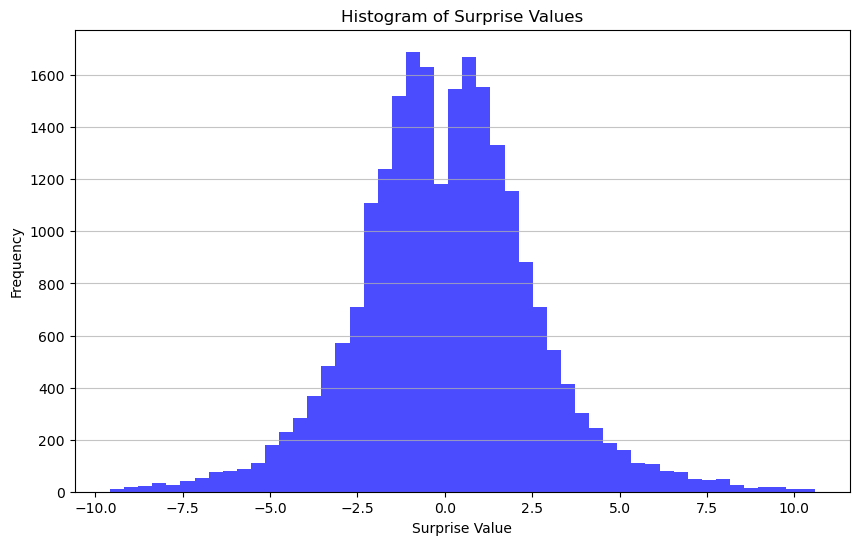

Length of ml_df: 23068


In [6]:
# Create a histogram of the 'Surprise' column
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(ml_df['Surprise'], bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Surprise Values')
plt.xlabel('Surprise Value')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# print length of ml_df
print(f"Length of ml_df: {len(ml_df)}")

In [7]:
# Summary statistics for the following columns: R, Std Dev, Surprise, # ests. and calculate # observations, mean, median, std, min, max from df_surprise dataframe
# First convert the columns to numeric if they are not already
# make sure to round to 3 decimal places
# Define the columns for which to calculate statistics
stat_columns = ['R', 'Std Dev', 'Surprise', '# Ests.']

# Convert the specified columns to a numeric type.
# 'errors='coerce'' will turn any non-numeric values into NaN (Not a Number).
for col in stat_columns:
    df_surprise[col] = pd.to_numeric(df_surprise[col], errors='coerce')

# Calculate the desired summary statistics using the .agg() method.
# This is a more direct way to compute specific statistics.
# We then transpose the result with .T to have the statistics as columns.
summary_stats = df_surprise[stat_columns].agg(
    ['count', 'mean', 'median', 'std', 'min', 'max']
).T

# Rename the columns to your desired names for the final table.
summary_stats = summary_stats.rename(columns={
    'count': '# Observations',
    'mean': 'Mean',
    'median': 'Median',
    'std': 'Std',
    'min': 'Min',
    'max': 'Max'
})

# Round all numeric values in the DataFrame to 3 decimal places.
summary_stats = summary_stats.round(3)

# The '# Observations' column represents a count, so it should be an integer.
# We convert its type after rounding to ensure it's displayed correctly.
summary_stats['# Observations'] = summary_stats['# Observations'].astype(int)

# Display the final, formatted summary statistics table.
print("\n--- Summary Statistics ---")
print(summary_stats)


--- Summary Statistics ---
          # Observations    Mean  Median     Std   Min       Max
R                  23169  63.176  69.482  28.853  0.00    99.259
Std Dev            23169   8.326   0.700  63.030  0.00  3243.170
Surprise           23169   0.028  -0.010   2.552 -9.58    10.580
# Ests.            23169  37.120  37.000  24.029  3.00   139.000


In [8]:
# --- Summary Statistics for df_es ---

# Define the columns for which to calculate statistics
stat_columns_es = ['Open', 'High', 'Low', 'Close', 'Volume']

# Note: The sample df_es data is already numeric, but this conversion step is
# good practice to ensure the code is robust.
for col in stat_columns_es:
    df_es[col] = pd.to_numeric(df_es[col], errors='coerce')

# Calculate the same summary statistics for the df_es dataframe
summary_stats_es = df_es[stat_columns_es].agg(
    ['count', 'mean', 'median', 'std', 'min', 'max']
).T

# Rename the columns for the final table.
summary_stats_es = summary_stats_es.rename(columns={
    'count': '# Observations', 'mean': 'Mean', 'median': 'Median',
    'std': 'Std', 'min': 'Min', 'max': 'Max'
})

# Round all numeric values in the DataFrame to 3 decimal places.
summary_stats_es = summary_stats_es.round(3)

# Convert the '# Observations' column to an integer.
summary_stats_es['# Observations'] = summary_stats_es['# Observations'].astype(int)

# Display the final, formatted summary statistics table.
print("\n--- Summary Statistics for ES DataFrame ---")
print(summary_stats_es)


--- Summary Statistics for ES DataFrame ---
        # Observations      Mean   Median       Std  Min        Max
Open           9682635  2156.417  1500.80  1314.442  0.0    6181.13
High           9682635  2156.745  1500.88  1314.631  0.0    6181.89
Low            9682635  2156.088  1500.56  1314.250  0.0    6179.36
Close          9682635  2156.417  1500.80  1314.442  0.0    6181.13
Volume         9682635   864.230    91.00  2243.275  0.0  214982.00


In [9]:
# for surprise dataset print out number of unique Ticker
unique_tickers = df_surprise['Ticker'].nunique()
print(f"\nNumber of unique tickers in the surprise dataset: {unique_tickers}")


Number of unique tickers in the surprise dataset: 161
